### opdracht 2



In [2]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from numpy.linalg import norm
import gensim 

# preprocess de zinnen
import nltk
import re
from nltk.corpus import stopwords
from unidecode import unidecode

# plot the pca
import matplotlib.pyplot as plt

### make the matrix 

In [3]:
line = np.array('altijd november altijd regen altijd dit lege hart altijd'.split())
enc = OneHotEncoder()
data = enc.fit_transform(line.reshape(-1, 1))

corpus = {'altijd':1, 'dit':2, 'hart':3, 'lege':4, 'november':5, 'regen':6}
data = [corpus[k] for k in 
    'altijd november altijd regen altijd dit lege hart altijd'.split()]

### import the model

In [4]:
model_path = "BioWordVec_PubMed_MIMICIII_d200.vec.bin"
model = gensim.models.KeyedVectors.load_word2vec_format(model_path, binary=True)
#kijken of het model goed is geladen
len(model.key_to_index) #16545452

#het model positioneert de woorden in een 200-dimensionale vectorruimte
s = model['man']
type(s) #ndarray
s.shape #(200,)


(200,)

### Cosinusgelijkheid

In [5]:
def cosine_similarity(vec1, vec2):
    # bereken dot product 
    dot_product = np.dot(vec1, vec2)

    # bereken de norm van elke vector
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    
    # bereken cosinusgelijkheid
    similarity = dot_product / (norm_vec1 * norm_vec2)

    return similarity


vector1 = np.array([1, 2, 3])
vector2 = np.array([4, 5, 6])

resultaat = cosine_similarity(vector1, vector2)
print(f"Cosine Similarity: {resultaat}")

Cosine Similarity: 0.9746318461970762


### preprocess de zinnen

In [6]:
# Download stopwoordenlijst (eenmalig)
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\isabe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
def preprocess_sentence(sentence):
    # Zet om naar kleine letters
    sentence = sentence.lower()
    
    # Verwijder de/het/een tekens
    sentence = unidecode(sentence)
    
    # Verwijder interpunctie en speciale tekens, behoud alleen letters en spaties
    sentence = re.sub(r'[^a-z\s]', '', sentence)
    
    # Verwijder stopwoorden
    stop_words = set(stopwords.words('dutch'))  # Voor Nederlands, gebruik 'english' voor Engels
    words = sentence.split()
    filtered_words = [word for word in words if word not in stop_words]
    
    # Zet de woorden terug naar een zin
    processed_sentence = ' '.join(filtered_words)
    
    return processed_sentence

# Voorbeeldgebruik
zin = "Hallo, wereld! Dit is een voorbeeldzin met diakritische tekens: naïve en résumé."
print(preprocess_sentence(zin))

hallo wereld voorbeeldzin diakritische tekens naive resume


### gelijkheid van twee zinnen



In [8]:
def sentence_to_vector(sentence, model):
    # Preprocess de zin
    sentence = preprocess_sentence(sentence)
    
    # Split de zin in woorden
    words = sentence.split()
    
    # Haal de vectoren op voor de woorden
    word_vectors = []
    for word in words:
        if word in model:
            word_vectors.append(model[word])
    
    # Bereken het gemiddelde van de woordembeddings (indien er woorden zijn)
    if word_vectors:
        sentence_vector = np.mean(word_vectors, axis=0)
    else:
        # Als er geen bekende woorden zijn in het model, retourneer een lege vector
        sentence_vector = np.zeros(model.vector_size)
    
    return sentence_vector

In [9]:
# Voorbeeldzinnen
zin1 = "Breast cancers with HER2 amplification have a higher risk of CNS metastasis and poorer prognosis."
zin2 = "Breast cancers with HER2 amplification are more aggressive, have a higher risk of CNS metastasis, and poorer prognosis."
zin3 = "Furthermore, increased CREB expression in breast tumors is associated with poor prognosis, shorter survival and higher risk of metastasis."

# Zet zinnen om naar vectoren
vec1 = sentence_to_vector(zin1, model)
vec2 = sentence_to_vector(zin2, model)
vec3 = sentence_to_vector(zin3, model)

# Bereken de cosine similarity tussen de zinnen
sim12 = cosine_similarity(vec1, vec2)
sim13 = cosine_similarity(vec1, vec3)
sim23 = cosine_similarity(vec2, vec3)

print(f"Cosine Similarity tussen zin 1 en zin 2: {sim12}")
print(f"Cosine Similarity tussen zin 1 en zin 3: {sim13}")
print(f"Cosine Similarity tussen zin 2 en zin 3: {sim23}")

Cosine Similarity tussen zin 1 en zin 2: 0.9913076162338257
Cosine Similarity tussen zin 1 en zin 3: 0.9479348063468933
Cosine Similarity tussen zin 2 en zin 3: 0.9444634318351746


### Synoniemen: plotten van gelijkende woorden

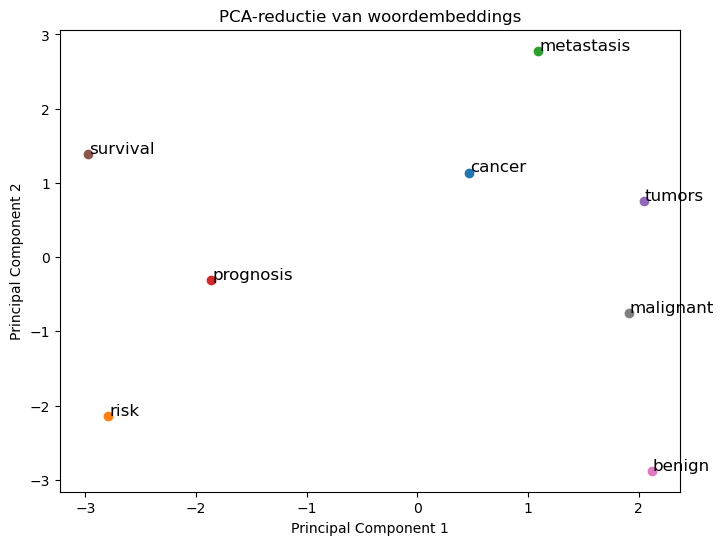

In [10]:
def compute_pca(X, n_components):
    # 1. Normaliseer de data (haal gemiddelde af)
    X_normalized = X - np.mean(X, axis=0)
    
    # 2. Bereken de covariantiematrix
    covariance_matrix = np.cov(X_normalized, rowvar=False)
    
    # 3. Bereken de eigenwaarden en eigenvectoren
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    
    # 4. Sorteer de eigenvectoren op basis van eigenwaarden (van hoog naar laag)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    top_eigenvectors = eigenvectors[:, sorted_indices[:n_components]]
    
    # 5. Projecteer de data op de belangrijkste eigenvectoren
    reduced_data = np.dot(X_normalized, top_eigenvectors)
    
    return reduced_data

# Voorbeeldwoorden en hun embeddings (gebruik de echte BioSentVec embeddings hier)
words = ['cancer', 'risk', 'metastasis', 'prognosis', 'tumors', 'survival', 'benign', 'malignant']
embeddings = np.array([model[word] for word in words])  # Zorg ervoor dat 'model' geladen is

# Voer PCA uit om terug te brengen naar 2 dimensies
reduced_embeddings = compute_pca(embeddings, n_components=2)

# Plot de woorden in 2D
plt.figure(figsize=(8, 6))
for i, word in enumerate(words):
    x, y = reduced_embeddings[i]
    plt.scatter(x, y)
    plt.text(x + 0.01, y + 0.01, word, fontsize=12)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA-reductie van woordembeddings')
plt.show()


In [17]:
# Controleer cosine similarity tussen enkele woorden
sim_benign_malignant = cosine_similarity(embeddings[4], embeddings[7])  # 'tumors' en 'malignant'

print(f"Cosine Similarity tussen 'benign' en 'malignant': {sim_benign_malignant:.4f}")

Cosine Similarity tussen 'benign' en 'malignant': 0.7836
